<a href="https://colab.research.google.com/github/CaQtiml/DeepLearning_Practice/blob/main/YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Input, ZeroPadding2D, LeakyReLU, UpSampling2D
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import time

In [ ]:
# import urllib.request
# with urllib.request.urlopen("https://academy.allaboutbirds.org/wp-content/uploads/2015/07/Cornell_Lab_of_Ornithology-Bird_feather_colors-887x591.jpg") as url:
#     image = np.asarray(bytearray(url.read()), dtype="uint8")
#     image = cv2.imdecode(image, cv2.IMREAD_COLOR)
#     print(image)

In [ ]:
# !streamlit run yolov3.py

In [1]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2022-01-07 04:04:54--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  61.4MB/s    in 4.1s    

2022-01-07 04:04:59 (57.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2022-01-07 04:04:59--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      


In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-0c57d7ba-c7ba-11dc-1b1e-fec043bcbb52)


In [3]:
def parse_cfg(cfgfile):
    with open(cfgfile, 'r') as file:
        lines = [line.rstrip('\n') for line in file if line != '\n' and line[0] != '#']
    holder = {}
    blocks = []
    for line in lines:
        if line[0] == '[':
            line = 'type=' + line[1:-1].rstrip()
            if len(holder) != 0:
                blocks.append(holder)
                holder = {}
        key, value = line.split("=")
        holder[key.rstrip()] = value.lstrip()
    blocks.append(holder)
    return blocks

In [7]:
blocks = parse_cfg("yolov3.cfg")
for block in blocks:
    print(block)
    print("=================")

{'type': 'net', 'batch': '64', 'subdivisions': '16', 'width': '608', 'height': '608', 'channels': '3', 'momentum': '0.9', 'decay': '0.0005', 'angle': '0', 'saturation': '1.5', 'exposure': '1.5', 'hue': '.1', 'learning_rate': '0.001', 'burn_in': '1000', 'max_batches': '500200', 'policy': 'steps', 'steps': '400000,450000', 'scales': '.1,.1'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '32', 'size': '3', 'stride': '1', 'pad': '1', 'activation': 'leaky'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '3', 'stride': '2', 'pad': '1', 'activation': 'leaky'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '32', 'size': '1', 'stride': '1', 'pad': '1', 'activation': 'leaky'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '3', 'stride': '1', 'pad': '1', 'activation': 'leaky'}
{'type': 'shortcut', 'from': '-3', 'activation': 'linear'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '128', 'size': '3'

In [ ]:
def YOLOv3Net(cfgfile, model_size, num_classes):
    blocks = parse_cfg(cfgfile)
    outputs = {}
    output_filters = []
    filters = 0
    out_pred = []
    scale = 0

    inputs = input_image = Input(shape=model_size)
    inputs = inputs / 255.0
    for i, block in enumerate(blocks[1:]):
      if (block["type"] == "convolutional"):
        activations = block["activation"]
        filters = int(block["filters"])
        kernel_size = int(block["size"])
        strides = int(block["stride"])
        if strides > 1:
          inputs = ZeroPadding2D(((1,0),(1,0)))(inputs)
        inputs = Conv2D(filters,
                        kernel_size,
                        strides=strides,
                        padding="valid" if strides>1 else "same",
                        name='conv_' + str(i),
                        use_bias=False if ("batch_normalize" in block) else True)(inputs)
        if "batch_normalize" in block:
          inputs = BatchNormalization(name='bnorm_' + str(i))(inputs)
          inputs = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(inputs)
      elif (block["type"] == "upsample"):
        stride = int(block["stride"])
        inputs = UpSampling2D(stride)(inputs)
      elif (block["type"] == "route"):
        block["layers"] = block["layers"].split(',')
        start = int(block["layers"][0])
        if len(block["layers"]) > 1:
          end = int(block["layers"][1]) - i
          filters = output_filters[i + start] + output_filters[end]
          inputs = tf.concat([outputs[i + start], outputs[i + end]], axis=-1)
        else:
          filters = output_filters[i + start]
          inputs = outputs[i + start]
      elif block["type"] == "shortcut":
        from_ = int(block["from"])
        inputs = outputs[i - 1] + outputs[i + from_]
      elif block["type"] == "yolo":
        mask = block["mask"].split(",")
        mask = [int(x) for x in mask]
        anchors = block["anchors"].split(",")
        anchors = [int(a) for a in anchors]
        anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
        anchors = [anchors[i] for i in mask]
        n_anchors = len(anchors)


        out_shape = inputs.get_shape().as_list()
        inputs = tf.reshape(inputs, [-1, n_anchors * out_shape[1] * out_shape[2], 5 + num_classes])

        box_centers = inputs[:, :, 0:2]
        box_shapes = inputs[:, :, 2:4]
        confidence = inputs[:, :, 4:5]
        classes = inputs[:, :, 5:num_classes + 5]


        box_centers = tf.sigmoid(box_centers)
        confidence = tf.sigmoid(confidence)
        classes = tf.sigmoid(classes)
        anchors = tf.tile(anchors, [out_shape[1] * out_shape[2], 1])
        box_shapes = tf.exp(box_shapes) * tf.cast(anchors, dtype=tf.float32) # element-wise multiplication


        x = tf.range(out_shape[1], dtype=tf.float32)
        y = tf.range(out_shape[2], dtype=tf.float32)
        cx, cy = tf.meshgrid(x, y)
        cx = tf.reshape(cx, (-1, 1))
        cy = tf.reshape(cy, (-1, 1))
        cxy = tf.concat([cx, cy], axis=-1)
        cxy = tf.tile(cxy, [1, n_anchors])
        cxy = tf.reshape(cxy, [1, -1, 2])
        strides = (input_image.shape[1] // out_shape[1],
                    input_image.shape[2] // out_shape[2])
        box_centers = (box_centers + cxy) * strides
        prediction = tf.concat([box_centers, box_shapes, confidence, classes], axis=-1)


        if scale:
          out_pred = tf.concat([out_pred, prediction], axis=1)
        else:
          out_pred = prediction
          scale = 1

      outputs[i] = inputs
      output_filters.append(filters)

    model = Model(input_image, out_pred)
    return model

In [ ]:
def load_weights(model,cfgfile,weightfile):
    fp = open(weightfile, "rb")
    np.fromfile(fp, dtype=np.int32, count=5)
    blocks = parse_cfg(cfgfile)
    for i, block in enumerate(blocks[1:]):
        if (block["type"] == "convolutional"):
            conv_layer = model.get_layer('conv_' + str(i))
            filters = conv_layer.filters
            k_size = conv_layer.kernel_size[0]
            in_dim = conv_layer.input_shape[-1] 
            if "batch_normalize" in block:
                norm_layer = model.get_layer('bnorm_' + str(i))
                size = np.prod(norm_layer.get_weights()[0].shape)
                bn_weights = np.fromfile(fp, dtype=np.float32, count=4 * filters)
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
            else:
                conv_bias = np.fromfile(fp, dtype=np.float32, count=filters)
            conv_shape = (filters, in_dim, k_size, k_size)
            conv_weights = np.fromfile(
                fp, dtype=np.float32, count=np.product(conv_shape))
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])
            if "batch_normalize" in block:
                norm_layer.set_weights(bn_weights)
                conv_layer.set_weights([conv_weights])
            else:
                conv_layer.set_weights([conv_weights, conv_bias])
    assert len(fp.read()) == 0, 'failed to read all data'
    fp.close()

In [ ]:
def non_max_suppression(inputs, model_size, max_output_size, 
                        max_output_size_per_class, iou_threshold, confidence_threshold):
    bbox, confs, class_probs = tf.split(inputs, [4, 1, -1], axis=-1)
    bbox = bbox/model_size[0]
    scores = confs * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes = tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores = tf.reshape(scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class = max_output_size_per_class,
        max_total_size = max_output_size,
        iou_threshold = iou_threshold,
        score_threshold = confidence_threshold
    )
    return boxes, scores, classes, valid_detections

In [ ]:
def resize_image(inputs, modelsize):
    inputs= tf.image.resize(inputs, modelsize)
    return inputs

In [ ]:
def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names

In [ ]:
def output_boxes(inputs,model_size, max_output_size, max_output_size_per_class, 
                 iou_threshold, confidence_threshold):
    center_x, center_y, width, height, confidence, classes = tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)
    top_left_x = center_x - width / 2.0
    top_left_y = center_y - height / 2.0
    bottom_right_x = center_x + width / 2.0
    bottom_right_y = center_y + height / 2.0
    inputs = tf.concat([top_left_x, top_left_y, bottom_right_x,
                        bottom_right_y, confidence, classes], axis=-1)
    boxes_dicts = non_max_suppression(inputs, model_size, max_output_size, 
                                      max_output_size_per_class, iou_threshold, confidence_threshold)
    return boxes_dicts

In [ ]:
def genColorDict():
  color_dict = {}
  for i in range(85):
    color = tuple(np.random.choice(range(256), size=3))
    color_dict[i] = color
  return color_dict

In [ ]:
def draw_outputs(img, boxes, objectness, classes, nums, class_names):
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    print(nums)
    colorDict = genColorDict()
    boxes=np.array(boxes)
    for i in range(nums):
        x1y1 = tuple((boxes[i,0:2] * [img.shape[1],img.shape[0]]).astype(np.int32))
        x2y2 = tuple((boxes[i,2:4] * [img.shape[1],img.shape[0]]).astype(np.int32))
        (col1,col2,col3) = colorDict[int(classes[i])]
        col1 = int(col1)
        col2 = int(col2)
        col3 = int(col3)
        # print(int(classes[i]),col1,col2,col3)
        img = cv2.rectangle(img, (x1y1), (x2y2), (col1,col2,col3), 2)
        img = cv2.putText(img, 
                          f'{class_names[int(classes[i])]} {objectness[i]:.4f}',
                          (x1y1), 
                          cv2.FONT_HERSHEY_PLAIN, 
                          1, (0, 0, 255), 2)
    return img

In [ ]:
!mkdir images
!wget https://audimediacenter-a.akamaihd.net/system/production/media/77651/images/41fe36bf04e5b617668f4ae61de27157523547f7/A195566_blog.jpg?1582517310 -O images/test2.jpg

--2021-08-02 13:10:31--  https://audimediacenter-a.akamaihd.net/system/production/media/77651/images/41fe36bf04e5b617668f4ae61de27157523547f7/A195566_blog.jpg?1582517310
Resolving audimediacenter-a.akamaihd.net (audimediacenter-a.akamaihd.net)... 23.202.229.56, 23.202.229.42
Connecting to audimediacenter-a.akamaihd.net (audimediacenter-a.akamaihd.net)|23.202.229.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186045 (182K) [image/jpeg]
Saving to: ‘images/test2.jpg’

images/test2.jpg    100%[===================>] 181.68K  --.-KB/s    in 0.01s   

2021-08-02 13:10:31 (16.2 MB/s) - ‘images/test2.jpg’ saved [186045/186045]



In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"

model_size = (416, 416,3)
num_classes = 80
class_name = 'coco.names'
max_output_size = 40
max_output_size_per_class= 20
iou_threshold = 0.5
confidence_threshold = 0.5
cfgfile = 'yolov3.cfg'
weight = "yolov3.weights"
weightfile = 'weights/yolov3_weights'
img_path = "images/test2.jpg"

tf.Tensor(11, shape=(), dtype=int32)


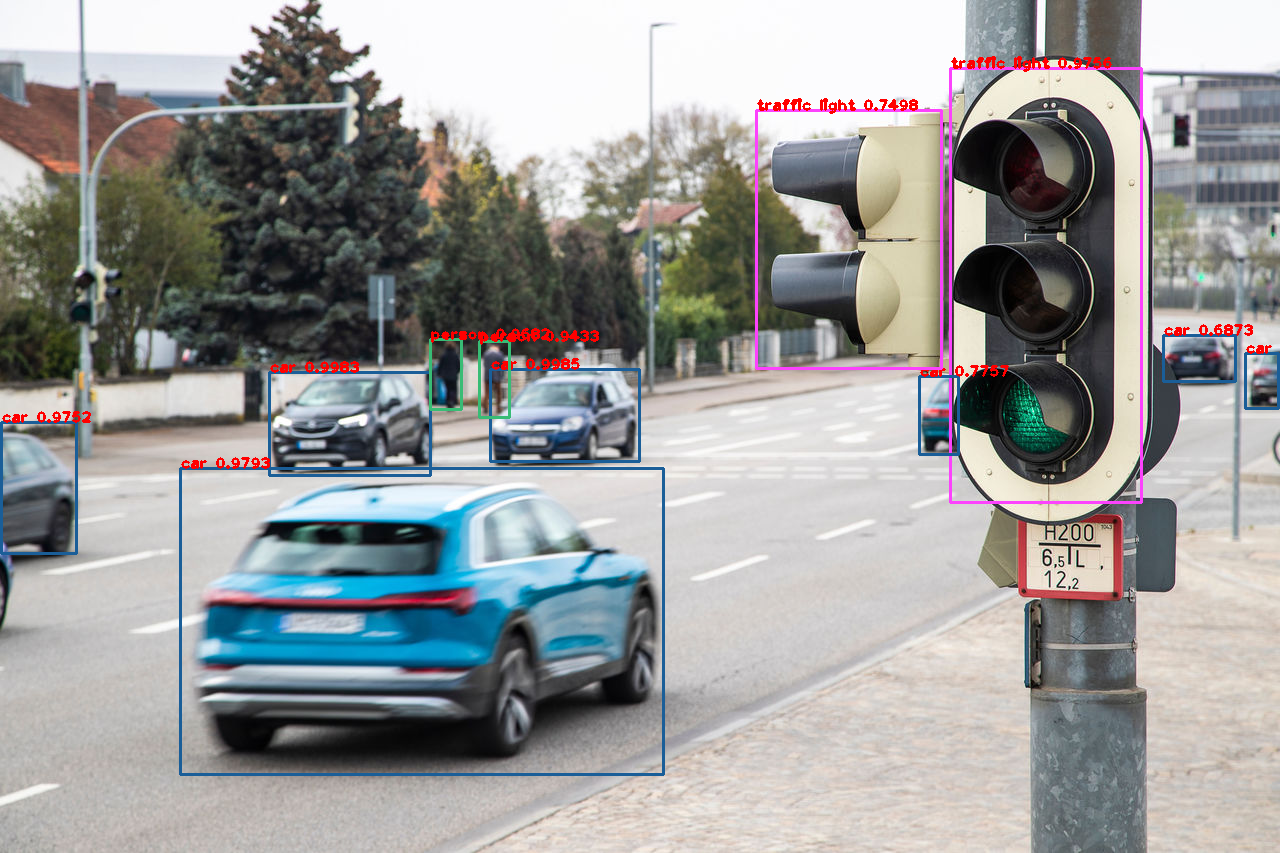

In [ ]:
model = YOLOv3Net(cfgfile,model_size,num_classes)
load_weights(model,cfgfile,weight)
# try:
#     model.save_weights('weights/yolov3_weights')
#     print('\nThe file \'yolov3_weights\' has been saved successfully.')
# except IOError:
#     print("Couldn't write the file \'yolov3_weights\'.")
# model.load_weights(weightfile)
class_names = load_class_names(class_name)
image = cv2.imread(img_path)
image = np.array(image)
image = tf.expand_dims(image, 0)
resized_frame = resize_image(image, (model_size[0],model_size[1]))
pred = model.predict(resized_frame)
boxes, scores, classes, nums = output_boxes(
    pred, model_size,
    max_output_size=max_output_size,
    max_output_size_per_class=max_output_size_per_class,
    iou_threshold=iou_threshold,
    confidence_threshold=confidence_threshold)
image = np.squeeze(image)
img = draw_outputs(image, boxes, scores, classes, nums, class_names)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Save the result
#cv2.imwrite('test.jpg', img)

In [ ]:
model.save("model_yolov3.h5")

tf.Tensor(11, shape=(), dtype=int32)


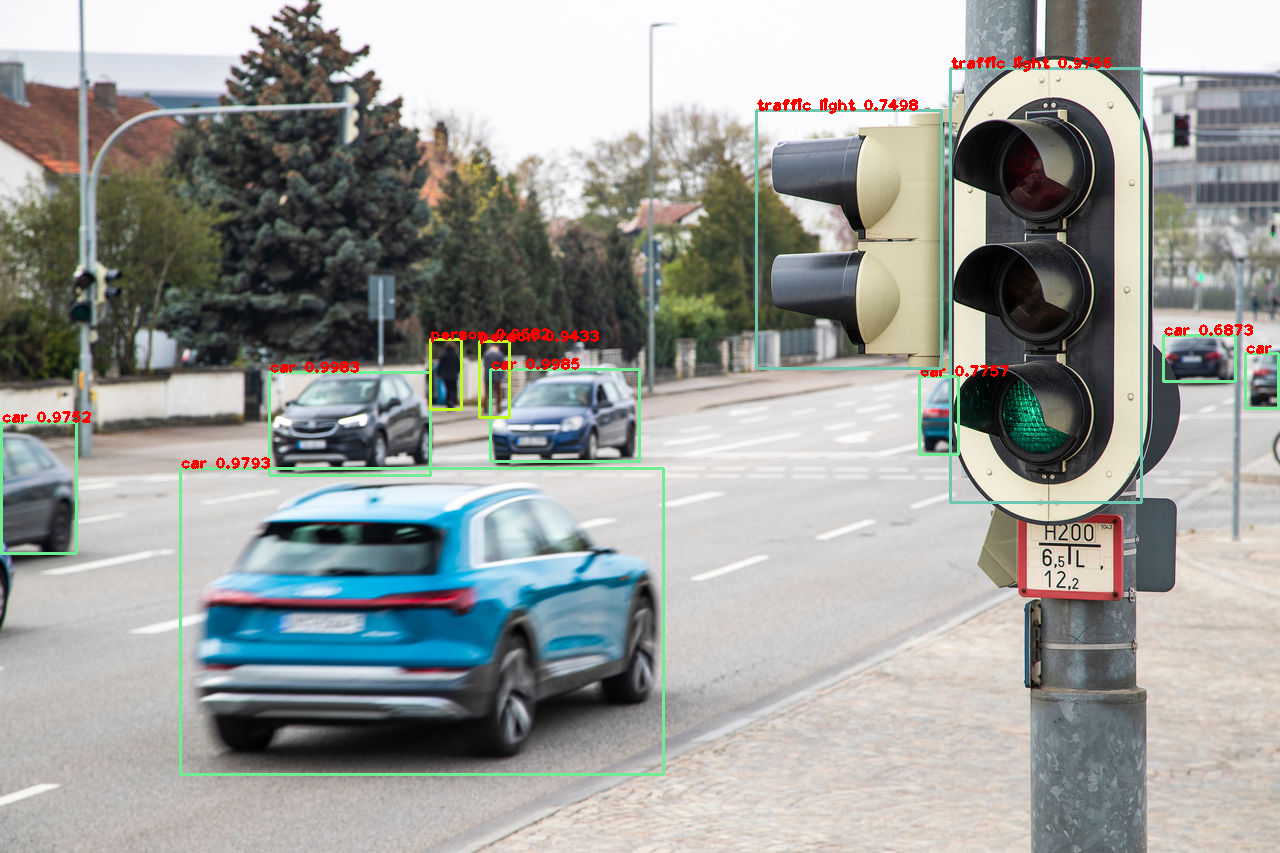

In [ ]:
loaded_model = tf.keras.models.load_model("model_yolov3.h5")
class_names = load_class_names(class_name)
image = cv2.imread(img_path)
image = np.array(image)
image = tf.expand_dims(image, 0)
resized_frame = resize_image(image, (model_size[0],model_size[1]))
pred = loaded_model.predict(resized_frame)
boxes, scores, classes, nums = output_boxes(
    pred, model_size,
    max_output_size=max_output_size,
    max_output_size_per_class=max_output_size_per_class,
    iou_threshold=iou_threshold,
    confidence_threshold=confidence_threshold)
image = np.squeeze(image)
img = draw_outputs(image, boxes, scores, classes, nums, class_names)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def test():
  color_dict = {}
  for i in range(85):
    color = tuple(np.random.choice(range(256), size=3))
    color_dict[i] = color 
  return color_dict
# print(color_dict)

col_dict = test()

print(col_dict[1])
print(col_dict[1])
print(col_dict[1])
# print(type((112,112,112)))

(158, 110, 208)
(158, 110, 208)
(158, 110, 208)


In [ ]:
# with urllib.request.urlopen("https://audimediacenter-a.akamaihd.net/system/production/media/77651/images/41fe36bf04e5b617668f4ae61de27157523547f7/A195566_blog.jpg?1582517310") as url:
#     image = np.asarray(bytearray(url.read()), dtype="uint8")
#     image = cv2.imdecode(image, cv2.IMREAD_ANYCOLOR)
#     image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)